In [9]:
import pandas as pd
import os
from nimlab import datasets as nimds
from calvin_utils.nifti_utils.matrix_utilities import unmask_matrix
from calvin_utils.nifti_utils.generate_nifti import view_and_save_nifti
from nilearn import image

Enter Relevant Information

In [17]:
# #If P-values stored in a csv:
# masked_p_values_path = '/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_PD_DBS_STN_WURZBURG/response_topology/voxelwise_glm/stim_by_age/one_way_p_value_generated_nifti.nii'
# masked_p_values_df = pd.read_csv(masked_p_values_path)
#If P-values stored in a nifti:
p_values_nifti_path = '/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_AD_DBS_FORNIX/response_topology/voxelwise_mixed_effects/age-stim-interaction_pd-vs-ad/uncorrected/Standardized_Age_voxel_p_value_generated_nifti.nii'

out_dir = '/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_AD_DBS_FORNIX/response_topology/voxelwise_mixed_effects/age-stim-interaction_pd-vs-ad/corrected_p_vals'
os.makedirs(out_dir, exist_ok=True)

Recompose P-Values

In [11]:
umasked_p_values_df = unmask_matrix(masked_p_values_df, unmask_by='columns')
print('Nifti path is: ', out_dir+'uncorrected_p_values.nii')
view_and_save_nifti(umasked_p_values_df, out_dir=out_dir, output_name=f'uncorrected_p_values.nii')

NameError: name 'masked_p_values_df' is not defined

View Uncorrected Nifti


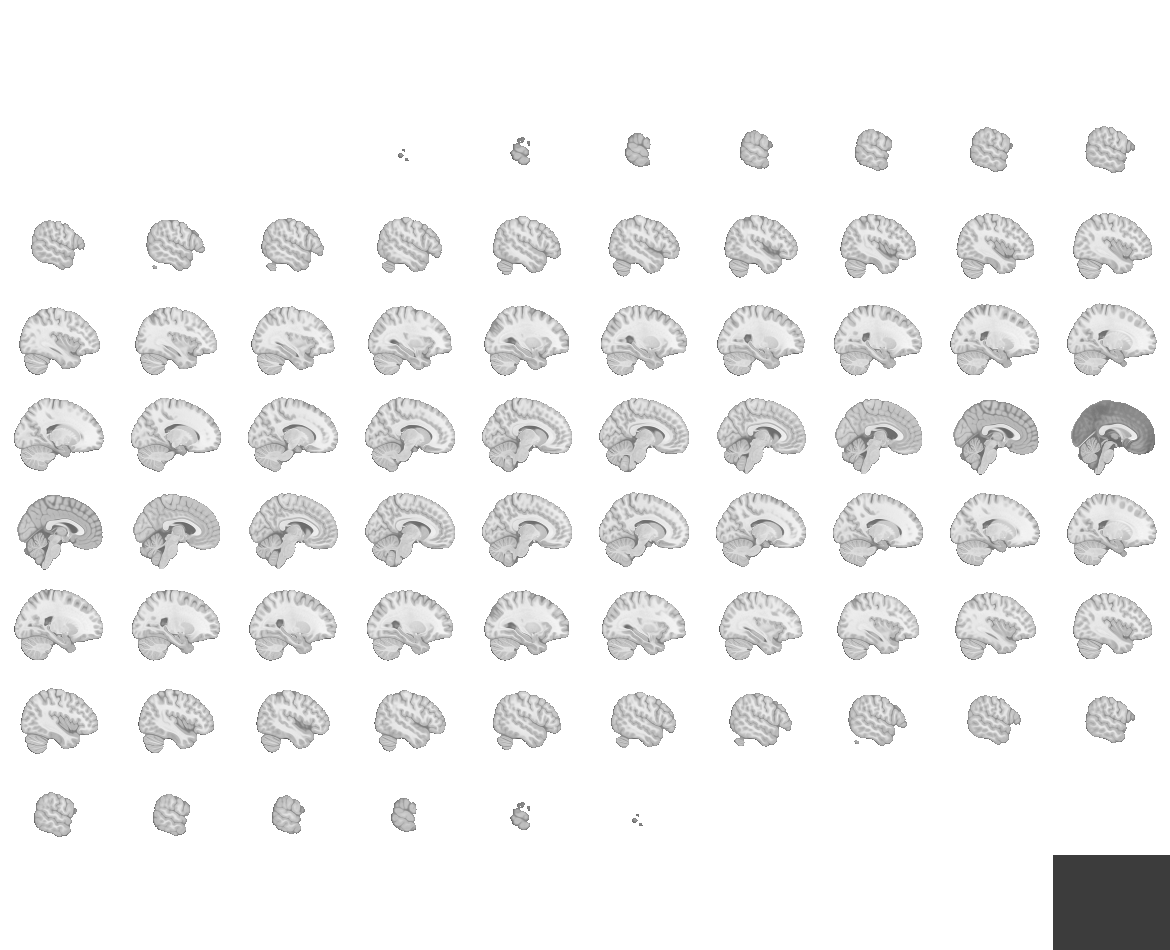
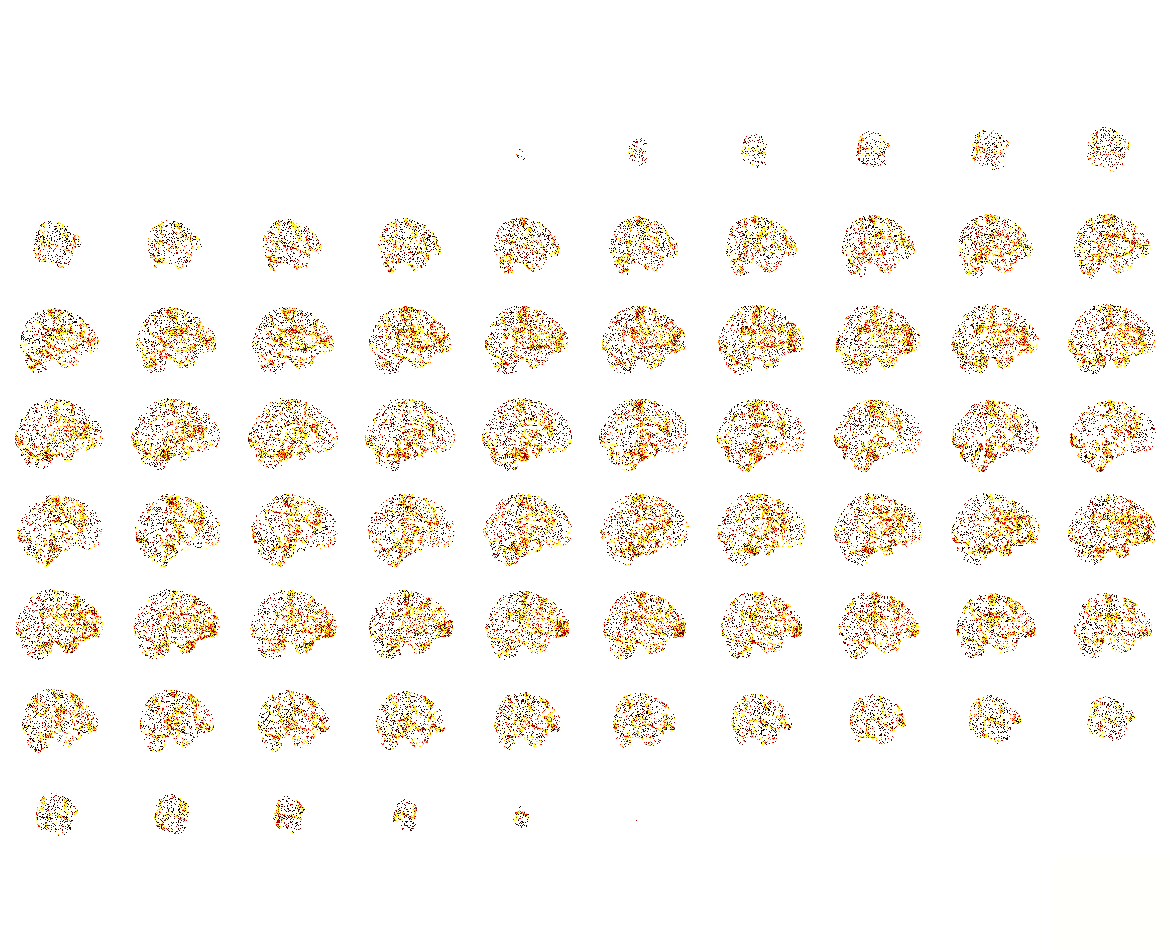

In [18]:
from calvin_utils.nifti_utils.matrix_utilities import view_nifti_html
view_nifti_html(image.load_img(p_values_nifti_path))

**Nilearn Correction**

This function, `apply_correction_and_save`, first loads a NIfTI file from the specified path and checks if it contains p-values or not. If the NIfTI file contains p-values, these are then converted to z-scores using the function `pvals_to_zscores` defined within. The z-scores conversion is necessary because the nilearn function `threshold_stats_img`, which applies multiple comparison correction methods, takes as input a statistical image in z-scale.

After the possible conversion, the `threshold_stats_img` function is used to apply the multiple comparison correction method specified by the `correction` parameter. This function applies a statistical threshold to the image and returns a thresholded image and the voxel-level threshold used.

The corrected image is then saved to the specified output directory and a HTML view of the corrected image is created using the `view_img` function from nilearn.

Let's break down the arguments of the function `apply_correction_and_save`:

- `nifti_file_path`: This is the file path to the NIfTI file which needs to be corrected.

- `correction`: This is the multiple comparisons correction method that should be applied to the image. The options are 'fpr', 'fdr', 'bonferroni' or None. These correspond to controlling the false positive rate, false discovery rate, or using Bonferroni correction, respectively. If None, then no correction is applied.

- `out_dir`: This is the directory where the corrected NIfTI image will be saved.

- `height_threshold`: This is the desired threshold of the statistical map. Anything below is set to NaN. If `height_control` is set to None.

- `cluster_threshold`: This is the cluster size threshold. In the returned thresholded map, sets of connected voxels (clusters) smaller than this number will be removed.
    - A cluster of 10 requires 10 connected voxels.

- `alpha`: This is the number controlling the thresholding, either a p-value or q-value. Its actual meaning depends on the `height_control` parameter.

- `two_sided`: This is a boolean indicating whether the thresholding should yield both positive and negative part of the maps. In that case, alpha is corrected by a factor of 2.

- `p_vals`: This is a boolean indicating whether the input NIfTI file contains p-values or not. If True, the p-values are converted to z-scores before applying the correction. 

The methodological reason to convert p-values to z-scores is that Z-scores are typically assumed by the algorithms used to correct for multiple comparisons, and the thresholding method will eradicate p-values. Abs(z) of 1.64 = p < 0.05. Abs(z) > 3.29 (equivalent to p < 0.001).

_______

Example of p-values correction:


Threshold the resulting map without multiple comparisons correction, abs(z) > 3.29 (equivalent to p < 0.001), cluster size > 10 voxels.

Arguments:
threshold=3.29,
cluster_threshold=10,
two_sided=True,


Now use FDR <.05 (False Discovery Rate) and no cluster-level threshold.

thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr"
)



Now use FWER <.05 (Family-Wise Error Rate) and no cluster-level threshold. As the data has not been intensively smoothed, we can use a simple Bonferroni correction.

thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)


Example: https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_thresholding.html


In [26]:
from nilearn.glm import threshold_stats_img
from nilearn import image, plotting
import nibabel as nib
import os
import scipy.stats as st
import numpy as np

def pvals_to_zscores(nifti_img):
    # Get the data from the NIfTI file
    pvals_data = np.nan_to_num(nifti_img.get_fdata(), nan=np.NaN, neginf=0.0000000000001, posinf=0.0000000000001)
    
    nonzero_pvals_data = pvals_data[pvals_data != 0]

    # Print minimum of nonzero elements
    # Convert p-values to z-scores
    # Note: we use '1 - pvals_data' because the p-values we have are for the right tail,
    # while st.norm.ppf() expects left tail p-values
    zscores_data = st.norm.ppf(1 - pvals_data)

    # Create a new NIfTI image with the z-score data, keeping the original header
    zscores_img = nib.Nifti1Image(zscores_data, nifti_img.affine, nifti_img.header)

    return zscores_img


def apply_correction_and_save(nifti_file_path, correction, out_dir, height_threshold, cluster_threshold, alpha, two_sided, p_vals=True, save=True):
    # Load the NIfTI file
    nifti_img = nib.load(nifti_file_path)
    
    if p_vals:
        nifti_img = pvals_to_zscores(nifti_img)
        print('Converted p-values to zscores')

    # Apply the specified correction
    thresholded_img, threshold = threshold_stats_img(stat_img=nifti_img, 
                                                     mask_img=None,
                                                     alpha=alpha, 
                                                     threshold=height_threshold,
                                                     cluster_threshold=cluster_threshold,
                                                     two_sided=two_sided,
                                                     height_control=correction)
    print(f"The {correction}=.05 threshold is {threshold:.3g}")
    # Save the corrected image
    corrected_nifti_file_path = os.path.join(out_dir, f'nilean_corrected_{correction}_p_values.nii.gz')
    if save:
        thresholded_img.to_filename(corrected_nifti_file_path)
    
    # Create an HTML view of the corrected image
    view = plotting.view_img(thresholded_img, cut_coords=(0,0,0), black_bg=False, opacity=.75, cmap='ocean_hot')

    return corrected_nifti_file_path, view


Enter method as: 'fdr', 'fpr', 'bonferroni', None

Converted p-values to zscores
The bonferroni=.05 threshold is 5.18
Saved to:,  /Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_AD_DBS_FORNIX/response_topology/voxelwise_mixed_effects/age-stim-interaction_pd-vs-ad/corrected_p_vals/nilean_corrected_bonferroni_p_values.nii.gz



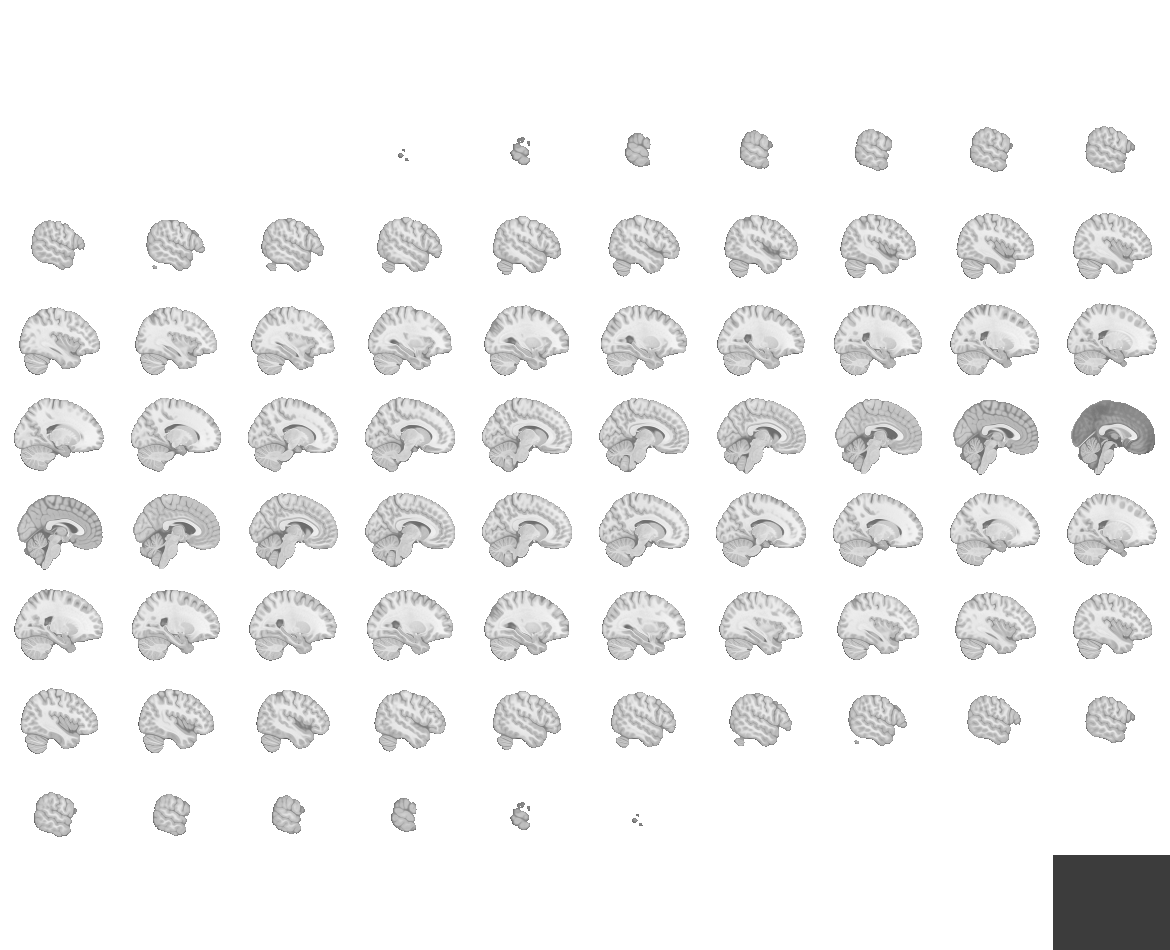
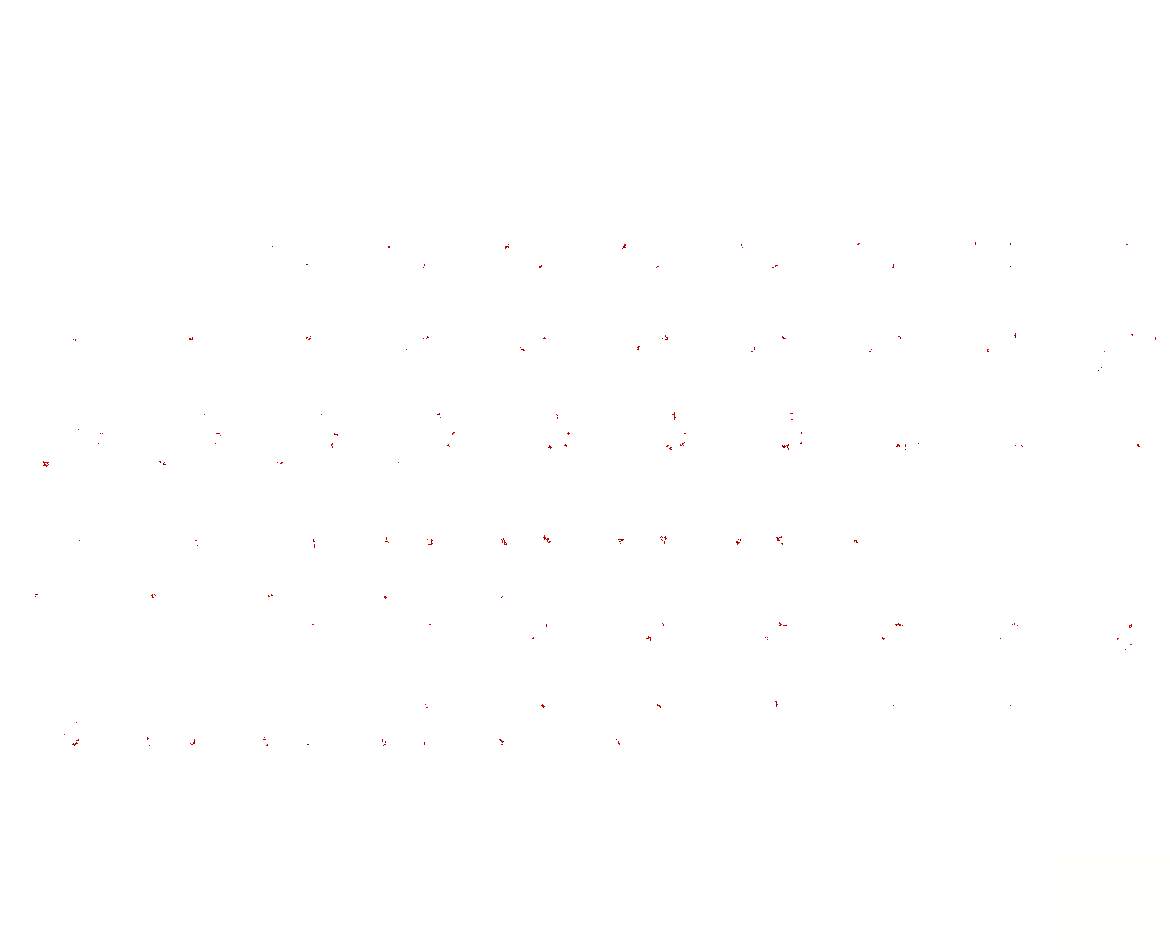

In [33]:
path, nifti = apply_correction_and_save(nifti_file_path=p_values_nifti_path, 
                                  correction='bonferroni', 
                                  alpha=0.05, 
                                  height_threshold=3,
                                  cluster_threshold=25,
                                  two_sided=True,
                                  out_dir=out_dir,
                                  save=True)
print('Saved to:, ', path)
nifti

Custom Correction Methods

In [22]:
#Define Correction methods
import numpy as np
from calvin_utils.nifti_utils.generate_nifti import view_and_save_nifti
from calvin_utils.nifti_utils.matrix_utilities import import_nifti_to_numpy_array
from statsmodels.stats.multitest import multipletests
from pathlib import PurePath

def apply_bonferroni(p_values):
    reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')
    return pvals_corrected


def apply_fdr_bh(p_values):
    reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    return pvals_corrected


def apply_fwer(p_values):
    reject, pvals_corrected, _, _ = multipletests(p_values, method='holm-sidak')
    return pvals_corrected

def apply_correction_and_save(p_val_nifti_path, correction, out_dir=out_dir):
    # Define a dictionary to map correction methods to corresponding functions
    corrections = {
        'bonferroni': apply_bonferroni,
        'fdr_bh': apply_fdr_bh,
        'fwer': apply_fwer
    }
    
    # Check if provided correction method is valid
    if correction not in corrections:
        raise ValueError(f"Invalid correction method. Expected one of: {list(corrections.keys())}")
    
    if isinstance(p_val_nifti_path, (str, PurePath)):
        p_values = import_nifti_to_numpy_array(p_val_nifti_path).ravel()
    else:
        raise ValueError(f"Invalid p_val_nifti_path argument passed. Expected path.")

    # Flatten p_values and apply specified correction
    p_values = p_values
    pvals_corrected = corrections[correction](p_values)

    # Set values > 0.05 to NaN
    pvals_corrected[pvals_corrected > 0.05] = np.nan

    # Create DataFrame and display
    corrected_pvals_df = pd.DataFrame(pvals_corrected.reshape(-1, 1))

    # Save as Nifti
    nifti = view_and_save_nifti(corrected_pvals_df, out_dir=out_dir, output_name=f'{correction}_p_values.nii')
    print('Saved to: ', out_dir)
    return nifti 


Apply Bonferroni Correction

In [23]:
p_values_nifti_path

'/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_AD_DBS_FORNIX/response_topology/voxelwise_mixed_effects/age-stim-interaction_pd-vs-ad/uncorrected/Standardized_Age_voxel_p_value_generated_nifti.nii'

Image saved to: 
 /Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_AD_DBS_FORNIX/response_topology/voxelwise_mixed_effects/age-stim-interaction_pd-vs-ad/corrected_p_vals
Saved to:  /Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_AD_DBS_FORNIX/response_topology/voxelwise_mixed_effects/age-stim-interaction_pd-vs-ad/corrected_p_vals



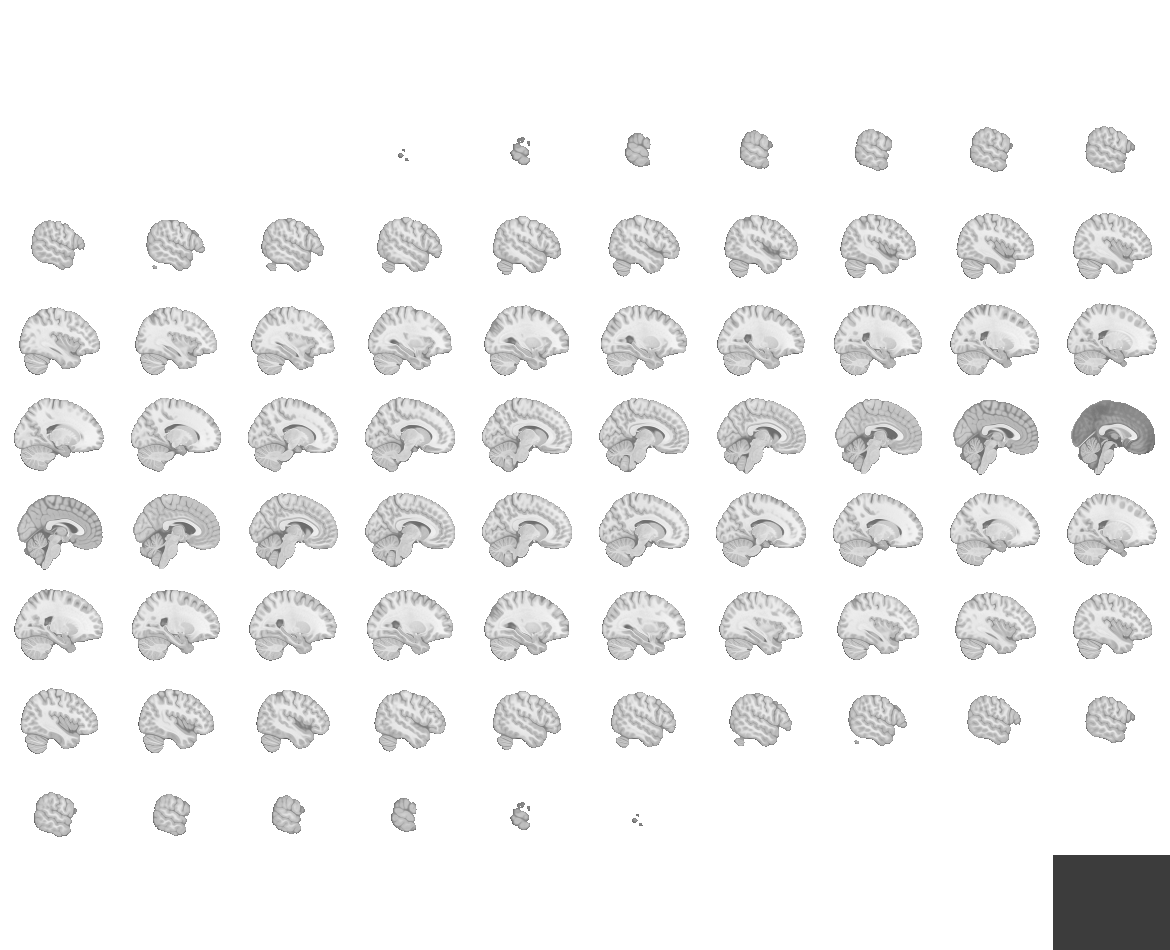
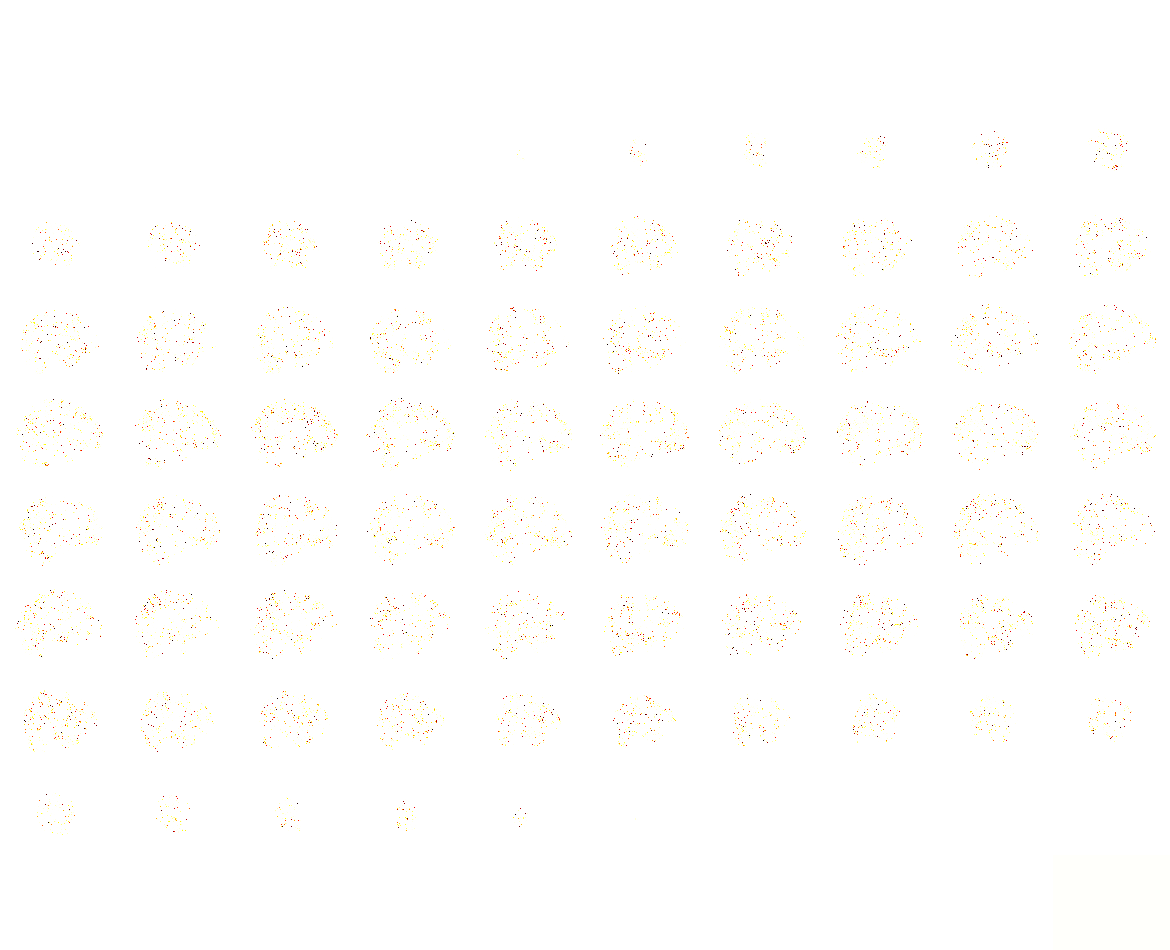

In [24]:
nifti = apply_correction_and_save(p_values_nifti_path, 'bonferroni')
nifti 


Apply FDR Correction

(91, 109, 91)
(902629, 1)
Image saved to: 
 /Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_PD_DBS_STN_WURZBURG/response_topology/voxelwise_glm/stim_by_age/corrected_p_vals
Saved to:  /Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_PD_DBS_STN_WURZBURG/response_topology/voxelwise_glm/stim_by_age/corrected_p_vals



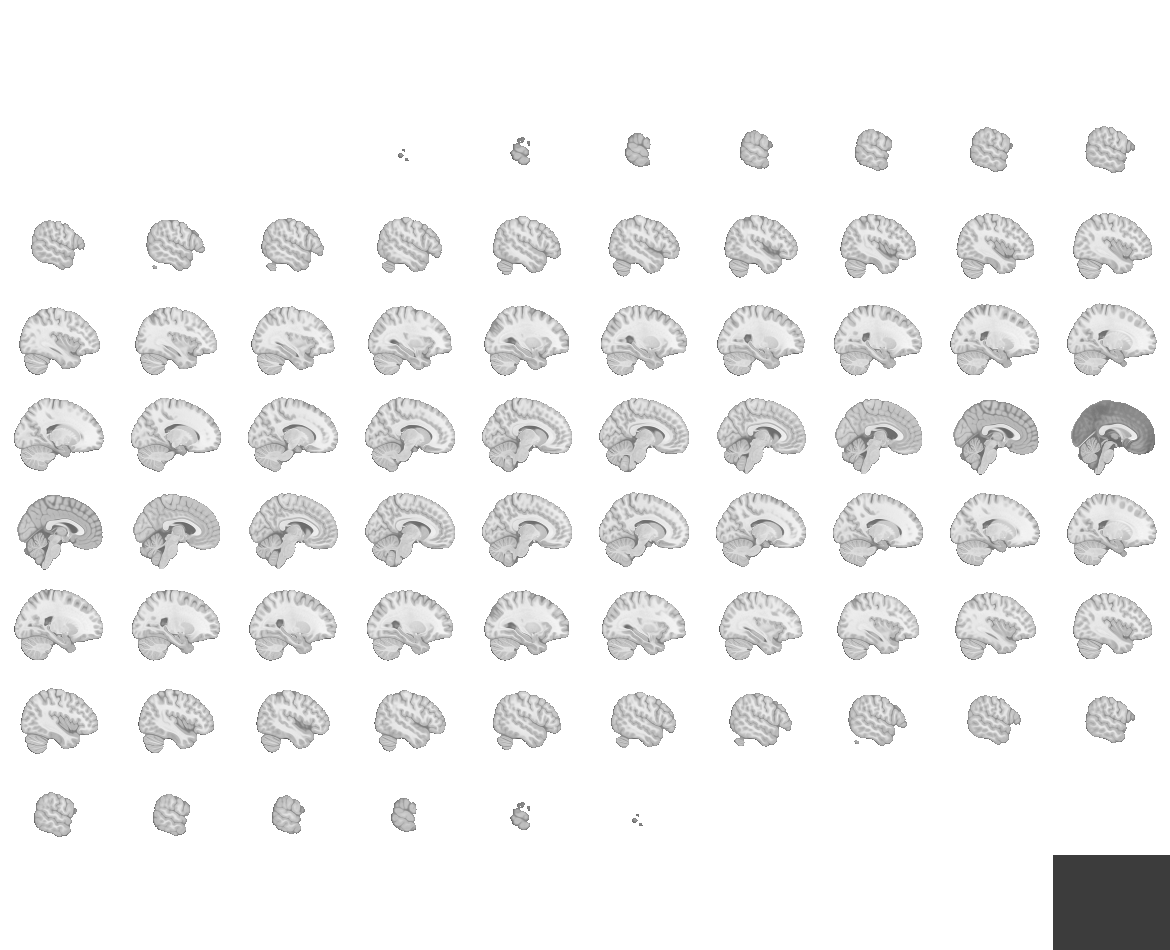
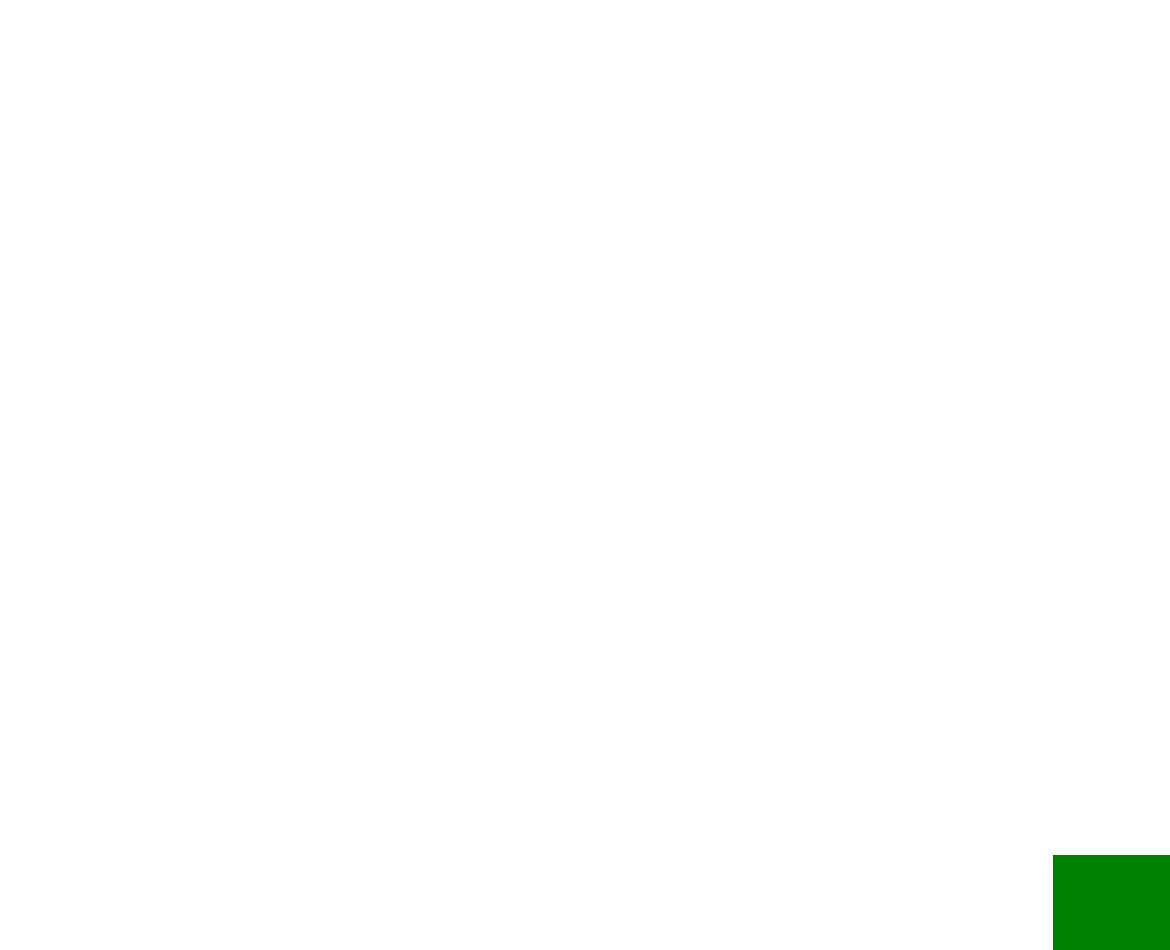

In [9]:
nifti = apply_correction_and_save(p_values_nifti_path, 'fdr_bh')
nifti 

FWER Correction

(91, 109, 91)
(902629, 1)
Image saved to: 
 /Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_PD_DBS_STN_WURZBURG/response_topology/voxelwise_glm/stim_by_age/corrected_p_vals
Saved to:  /Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_PD_DBS_STN_WURZBURG/response_topology/voxelwise_glm/stim_by_age/corrected_p_vals



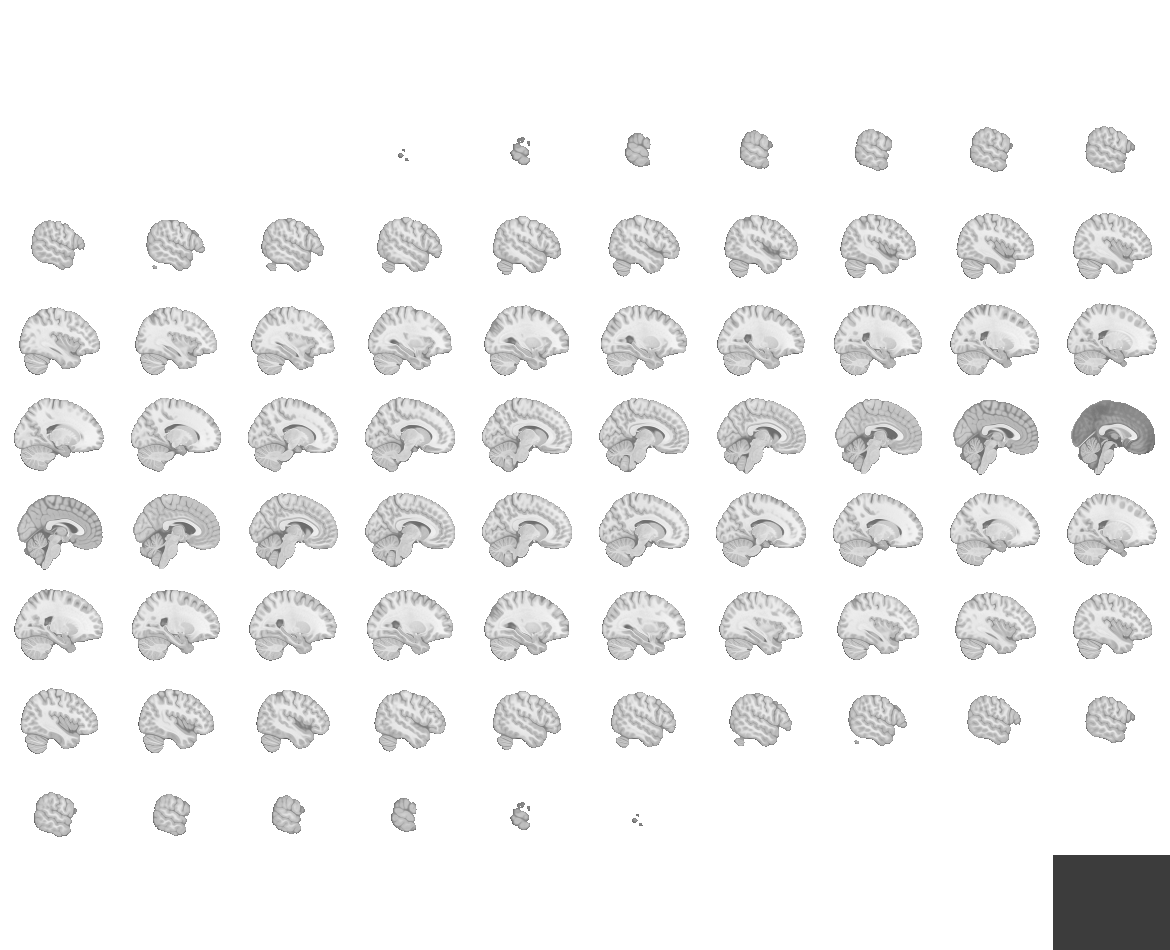
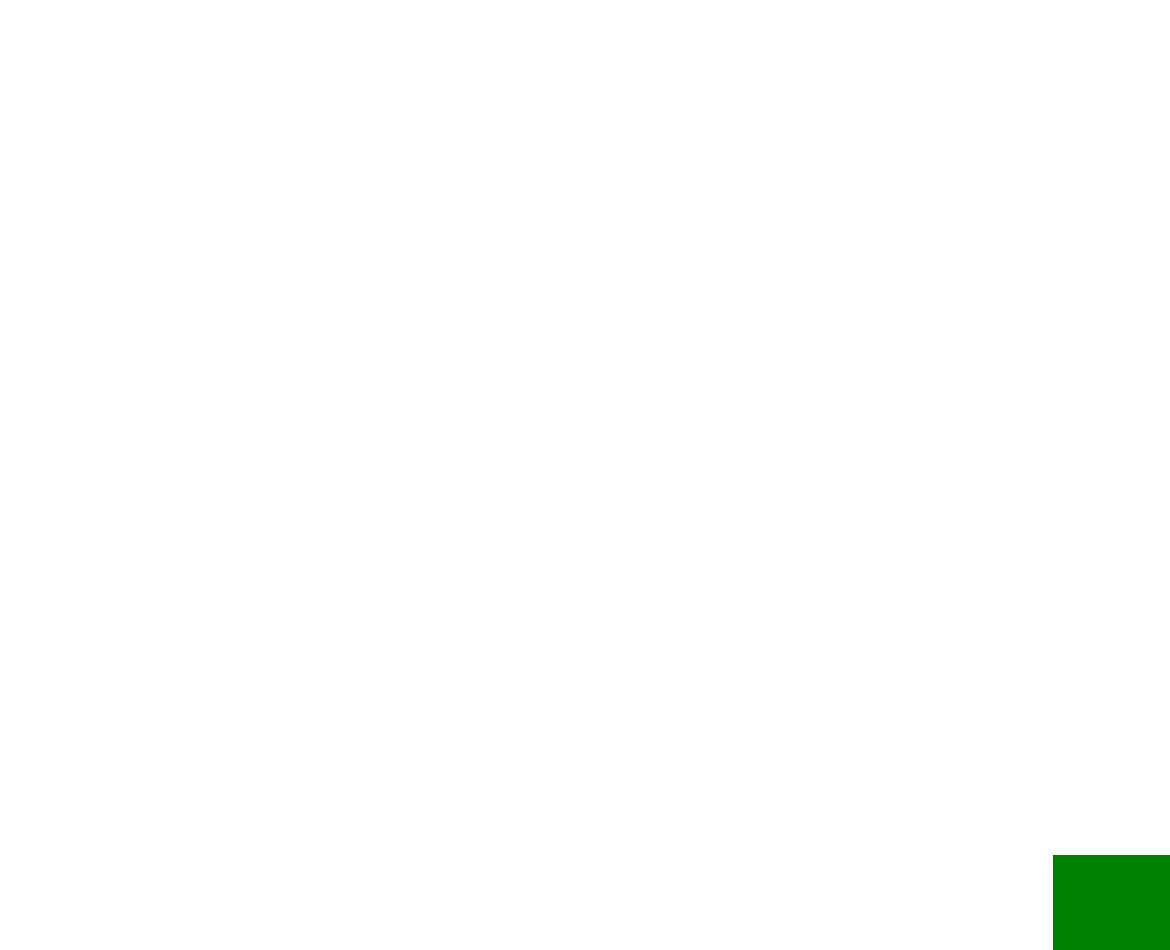

In [26]:
nifti = apply_correction_and_save(p_values_nifti_path, 'fwer')
nifti 